<a href="https://colab.research.google.com/github/RedietMT/Deep-Learning-Projects/blob/main/MileStone2_YOLOv8_Model_Train_and_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#YOLOV8 CELEBRITY DETECTION WITH GPU

# Step 1: Check GPU
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

# Step 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 3: Install ultralytics
!pip install -q ultralytics

# Step 4: Unzip dataset
import os
import zipfile

ZIP_PATH = '/content/drive/MyDrive/yolo_celeba_dataset_enhanced.zip'
EXTRACT_TO = '/content/dataset'

print("Extracting dataset...")
os.makedirs(EXTRACT_TO, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_TO)

print("✓ Dataset extracted")

# Step 5: Find and update data.yaml
print("\nFinding data.yaml...")
yaml_path = None

for root, dirs, files in os.walk(EXTRACT_TO):
    if 'data.yaml' in files:
        yaml_path = os.path.join(root, 'data.yaml')
        print(f"Found: {yaml_path}")
        break

if not yaml_path:
    raise FileNotFoundError("data.yaml not found!")

# Update yaml with correct paths
import yaml

with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)

# Update to absolute path
data['path'] = os.path.dirname(yaml_path)

with open(yaml_path, 'w') as f:
    yaml.dump(data, f)

print(f"✓ Updated data.yaml path: {data['path']}")

# Verify dataset structure
print(f"\nDataset structure:")
print(f"  Train images: {len(os.listdir(os.path.join(data['path'], 'images/train')))}")
print(f"  Val images: {len(os.listdir(os.path.join(data['path'], 'images/val')))}")

# Step 6: Train with GPU!
from ultralytics import YOLO

# OPTIMIZED FOR Limited RAM)

from ultralytics import YOLO

model = YOLO('yolov8n.pt')

print("\n" + "="*70)
print("TRAINING WITH GPU - Memory Optimized")
print("="*70)

results = model.train(
    data=yaml_path,
    epochs=50,
    imgsz=416,
    batch=16,
    device=0,
    project='/content/runs',
    name='celeb_detector',
    patience=15,
    save=True,
    plots=True,
    verbose=True,
    amp=True,
    cache=False,
    workers=2
)

print("\n✓ Training complete!")
print("="*70)

# Load class mapping
import pandas as pd

mapping_path = os.path.join(data['path'], 'class_mapping.csv')
class_mapping = pd.read_csv(mapping_path)
reverse_map = dict(zip(class_mapping['class_id'], class_mapping['celebrity_id']))

print(f"Loaded {len(class_mapping)} celebrity mappings")

# Test and visualize
trained_model = YOLO('/content/runs/celeb_detector/weights/best.pt')

val_img_dir = os.path.join(data['path'], 'images/val')
test_imgs = [os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)[:3]]

print("\nTesting on sample images:")
for img_path in test_imgs:
    results = trained_model(img_path)

    for result in results:
        boxes = result.boxes
        print(f"\n{os.path.basename(img_path)}:")
        print(f"  Detected {len(boxes)} celebrities:")

        for box in boxes:
            class_id = int(box.cls[0].item())
            conf = box.conf[0].item()
            celeb_id = reverse_map[class_id]
            print(f"    - Celebrity ID {celeb_id}: {conf:.2%}")

        # Save visualization
        save_path = f'/content/result_{os.path.basename(img_path)}'
        result.save(save_path)

# Display results
from IPython.display import Image, display
import matplotlib.pyplot as plt

print("\nVisualizing detections:")
for img_path in test_imgs:
    result_path = f'/content/result_{os.path.basename(img_path)}'
    if os.path.exists(result_path):
        display(Image(result_path))

# Save model to Google Drive
import shutil

best_model = '/content/runs/celeb_detector/weights/best.pt'
drive_path = '/content/drive/MyDrive/celeb_detector_best.pt'

shutil.copy(best_model, drive_path)
print(f"\n✓ Model saved to Google Drive: celeb_detector_best.pt")

# Print final metrics
print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
metrics = trained_model.val()
print(f"mAP50: {metrics.box.map50:.3f} ({metrics.box.map50*100:.1f}%)")
print(f"mAP50-95: {metrics.box.map:.3f} ({metrics.box.map*100:.1f}%)")

GPU Available: True
GPU Name: Tesla T4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting dataset...
✓ Dataset extracted

Finding data.yaml...
Found: /content/dataset/data.yaml
✓ Updated data.yaml path: /content/dataset

Dataset structure:
  Train images: 4128
  Val images: 700

TRAINING WITH GPU - Memory Optimized
Ultralytics 8.3.206 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=No

FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/celeb_detector/weights/best.pt'

TESTING TRAINED MODEL

[1] Running validation...
Ultralytics 8.3.206 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,014,813 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 855.0±319.2 MB/s, size: 23.4 KB)
val: Scanning /content/dataset/labels/val.cache... 700 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 700/700 342.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 44/44 5.9it/s 7.4s
                   all        700       1940      0.521      0.587      0.596      0.596
                     0         32         32      0.319      0.281      0.352      0.352
                     1         44         44      0.896       0.75      0.875      0.875
                     2         39         39      0.216      0.231      0.173      0.173
                     3         38         38      0.234      0.105      0.171      0.171
  

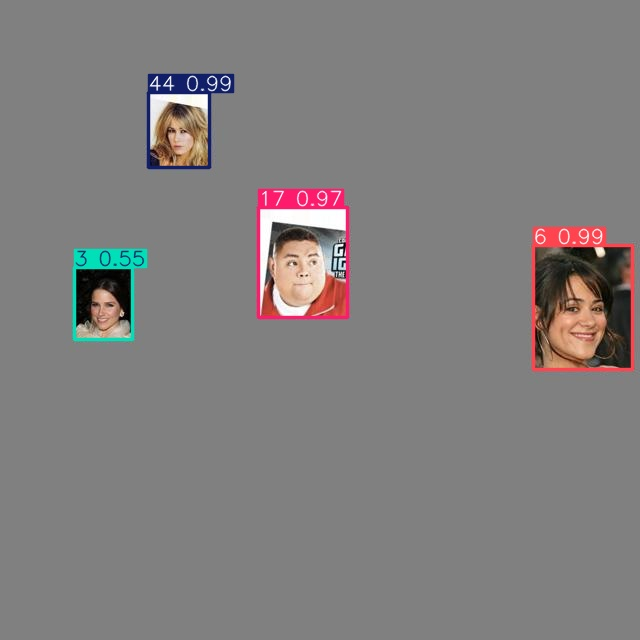


val_composite_00213.jpg:


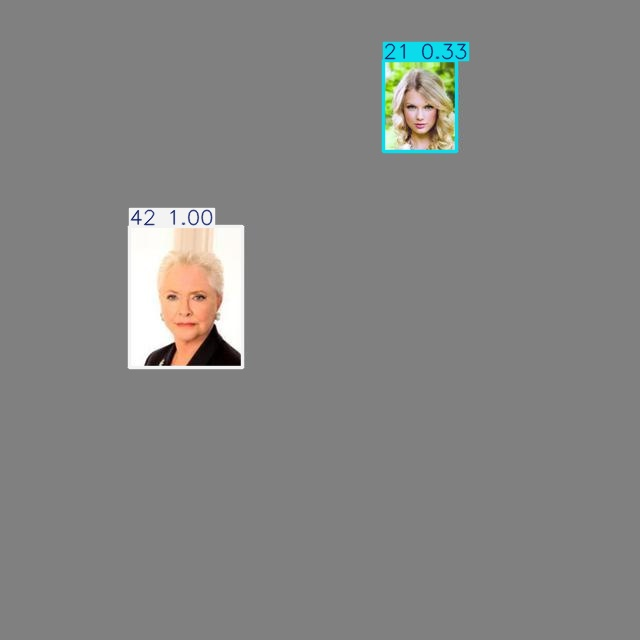


val_composite_00214.jpg:


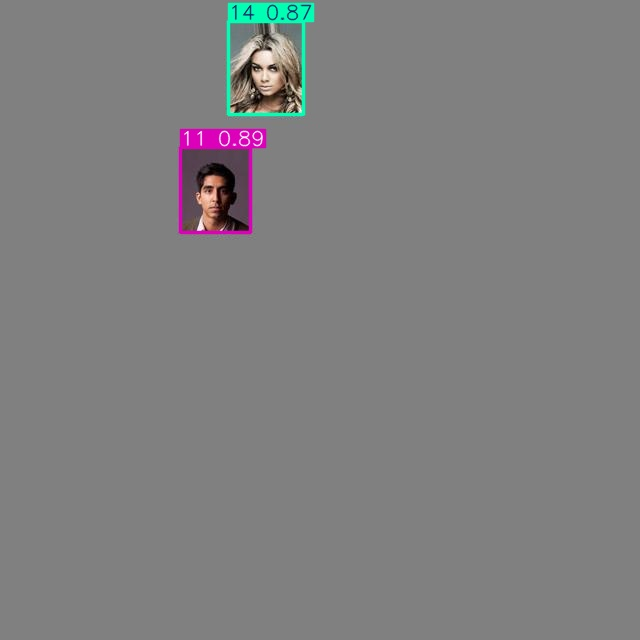


val_composite_00215.jpg:


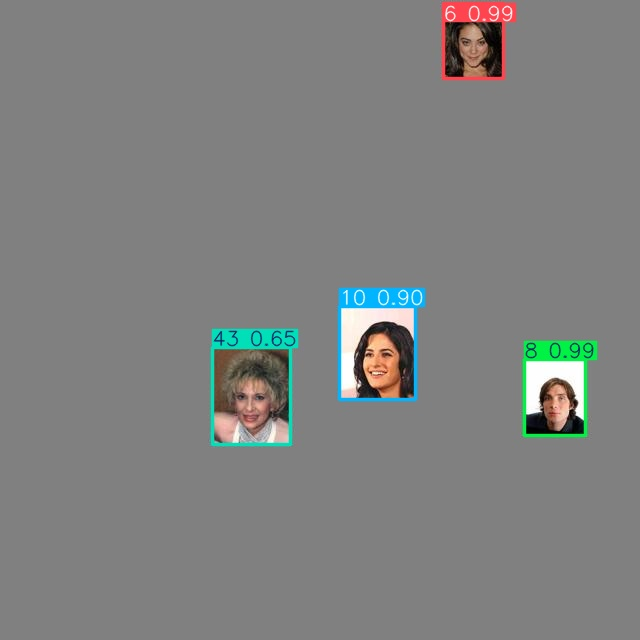


val_composite_00216.jpg:


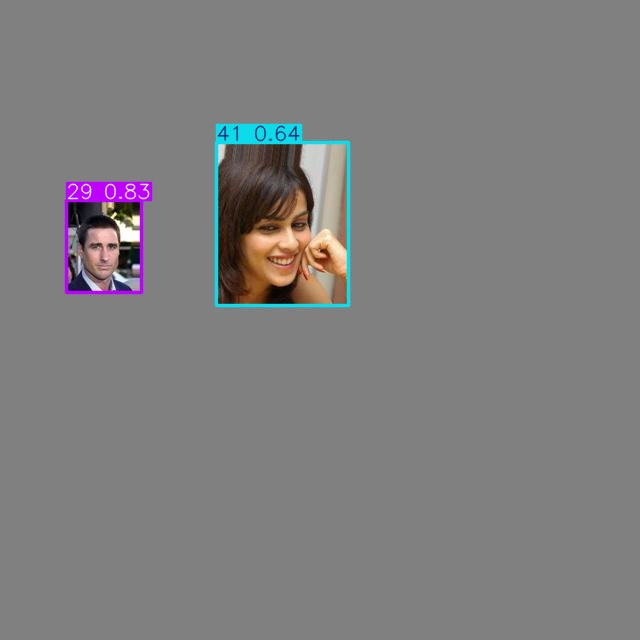


val_composite_00217.jpg:


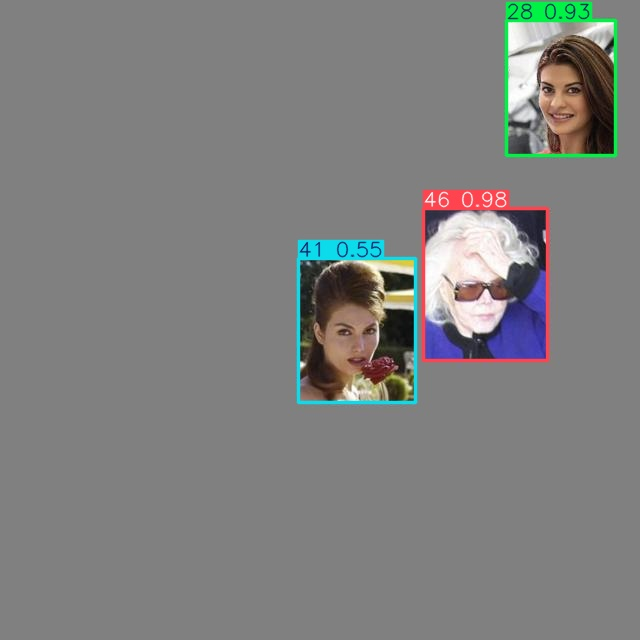


val_composite_00218.jpg:


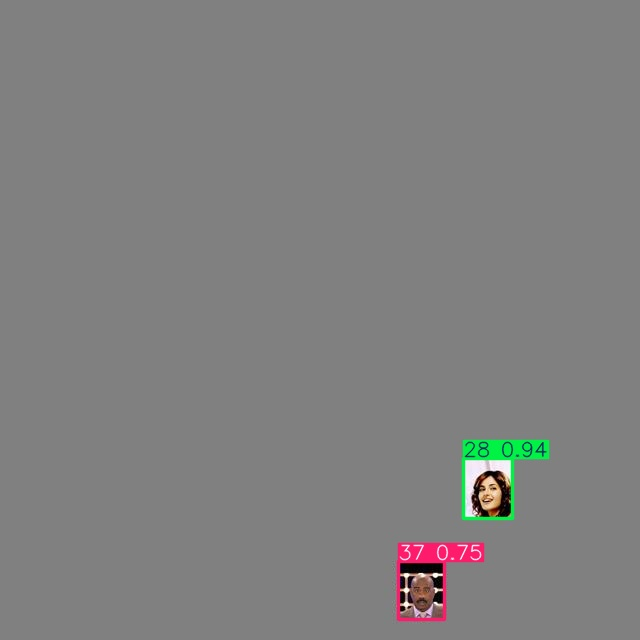


val_composite_00219.jpg:


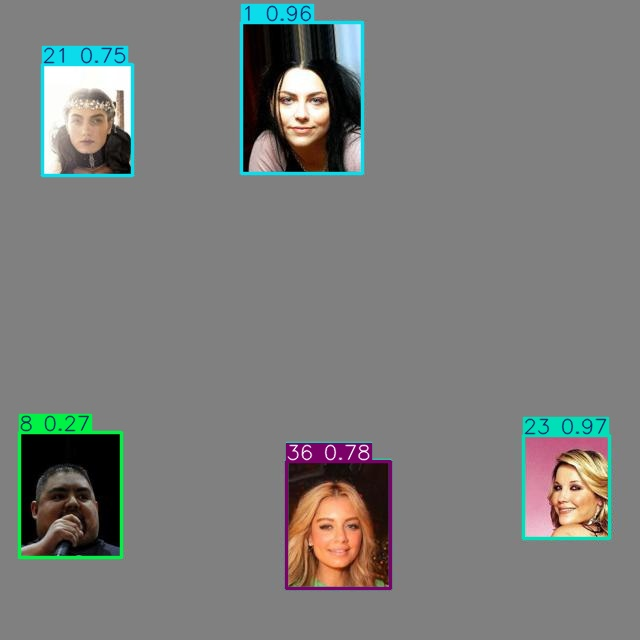


TESTING COMPLETE!


In [10]:
# TEST MODEL
from ultralytics import YOLO
import pandas as pd
import os
from IPython.display import Image, display

# Load trained model
trained_model = YOLO('/content/runs/celeb_detector2/weights/best.pt')

# Load class mapping
mapping_path = os.path.join(data['path'], 'class_mapping.csv')
class_mapping = pd.read_csv(mapping_path)
reverse_map = dict(zip(class_mapping['class_id'], class_mapping['celebrity_id']))

print("="*70)
print("TESTING TRAINED MODEL")
print("="*70)

# Validate on entire validation set

print("\n[1] Running validation...")
metrics = trained_model.val()
print(f"\nValidation Results:")
print(f"  mAP50: {metrics.box.map50:.3f} ({metrics.box.map50*100:.1f}%)")
print(f"  mAP50-95: {metrics.box.map:.3f} ({metrics.box.map*100:.1f}%)")

# TEST 2: Test on sample images
# ============================================================================
print("\n[2] Testing on sample images...")

val_img_dir = os.path.join(data['path'], 'images/val')
test_imgs = sorted([os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir) if f.endswith('.jpg')])[12:20]

for img_path in test_imgs:
    print(f"\n--- {os.path.basename(img_path)} ---")

    results = trained_model(img_path, conf=0.25)

    for result in results:
        boxes = result.boxes
        print(f"Detected {len(boxes)} celebrities:")

        for box in boxes:
            class_id = int(box.cls[0].item())
            conf = box.conf[0].item()
            celeb_id = reverse_map[class_id]
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            print(f"  - Celebrity ID {celeb_id}: {conf:.2%} at [{int(x1)}, {int(y1)}, {int(x2)}, {int(y2)}]")

        save_path = f'/content/result_{os.path.basename(img_path)}'
        result.save(save_path)

# TEST 3: Visualize with boxing
# ============================================================================
print("\n[3] Visualizing detections...")

for img_path in test_imgs:
    result_path = f'/content/result_{os.path.basename(img_path)}'
    if os.path.exists(result_path):
        print(f"\n{os.path.basename(img_path)}:")
        display(Image(result_path))

print("\n" + "="*70)
print("TESTING COMPLETE!")
print("="*70)